In [ ]:
# pyright: basic

# Lab Work #3
### Nedozhdii Oleksii FF-31mn


# Imports

In [1]:

import itertools
import string
import random
import re
import os

import numpy as np

import tensorflow as tf
from transformers import TrainingArguments, Trainer

import keras
from keras import layers
from keras.api.models import Model
from keras.api.applications import ResNet50

from transformers import BertTokenizerFast, BertForSequenceClassification

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = "plotly_dark"

2024-12-28 10:59:18.029883: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ned/.local/share/mamba/envs/data-scince/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Згорткові нейронні мережі
Вирішіть завдання класифікації зображень за допомогою згорткової (convolutional) нейромережі двома способами
- а) навчить мережу з нуля (from scratch)
- б) застосуйте перенесення навчання (transfer learning from pre-trained weights)
Порівняйте результати (якщо в обраному датасеті класів забагато, достатньо залишити 3-5).

## Load dataset 'Intel Image Classification'
classes: buildings, forest, glacier, mountain, sea, street

In [2]:

train_dir = "resources/intel_image_classification/seg_train/"
test_dir = "resources/intel_image_classification/seg_test/"
pred_dir = "resources/intel_image_classification/seg_test/"

img_size = (150, 150)

img_train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=42,
    batch_size=500,
    image_size=img_size,
    validation_split=0.2,
    subset="training",
)
img_val_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    image_size=img_size,
    shuffle=False,
)
img_test_ds = keras.preprocessing.image_dataset_from_directory(
    test_dir, seed=42, batch_size=500, image_size=img_size, shuffle=False
)
img_pred_ds = keras.preprocessing.image_dataset_from_directory(
    pred_dir, seed=42, image_size=img_size, shuffle=False
)

#img_true_labels = img_test_ds.class_names
img_train_class_names = img_test_ds.class_names
img_num_classes = len(img_train_class_names)
print(f"Classes: {img_train_class_names}")
print(f"Classes number: {img_num_classes}")


# collect one image per class
classified_images = {}

for image, label in img_train_ds.unbatch():
    print(label)# = np.argmax(label)
    class_name = img_train_class_names[label]
    if class_name not in classified_images:
        classified_images[class_name] = image
    if len(classified_images) == img_num_classes:
        break

NameError: name 'keras' is not defined

dict_keys(['street', 'sea', 'glacier', 'forest', 'mountain', 'buildings'])


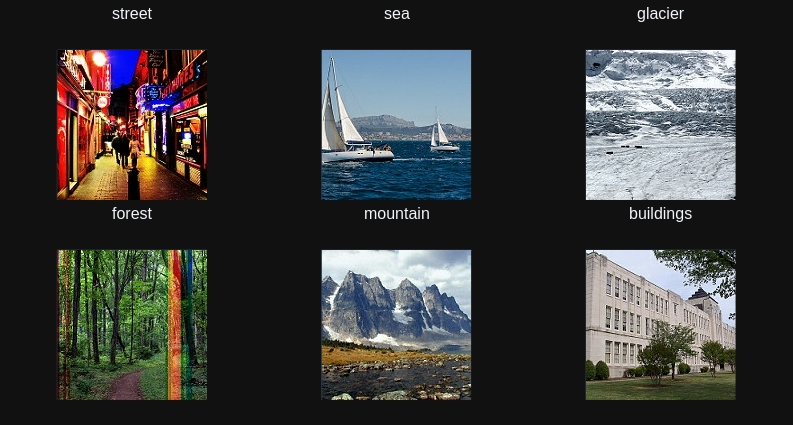

In [13]:
print(classified_images.keys())
fig = make_subplots(
    2,
    3,
    subplot_titles=list(classified_images.keys()),
    horizontal_spacing=0,
    vertical_spacing=0,
)
row_col_iter = itertools.product(range(1, 4), repeat=2)
for (row, col), image in zip(row_col_iter, classified_images.values()):
    img_data = np.array(image).astype("float64")
    fig.add_trace(px.imshow(img_data).data[0], row=row, col=col)
fig.update_layout(
    width=img_size[0] * 3,
    height=img_size[1] * 2 + 125,
    margin=dict(l=0, r=0, b=0, t=25),
)
fig.update_xaxes(showticklabels=False, showgrid=False)
fig.update_yaxes(showticklabels=False, showgrid=False)
fig.show()

## Convolutional network

In [17]:

conv_network = keras.Sequential()
conv_network.add(
    layers.Conv2D(
        input_shape=(*img_size, 3), filters=16, kernel_size=7, activation="relu"
    )
)
conv_network.add(layers.Conv2D(filters=32, kernel_size=5, activation="relu"))
conv_network.add(layers.MaxPooling2D())
conv_network.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
conv_network.add(layers.MaxPooling2D())
conv_network.add(layers.Flatten())
conv_network.add(layers.Dense(36, activation="relu"))
conv_network.add(layers.Dense(img_num_classes, activation="softmax"))

conv_network.compile(
    loss='sparse_categorical_crossentropy', optimizer="adam", metrics=["accuracy"]
)

conv_network.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 144, 144, 16)   │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 140, 140, 32)   │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 70, 70, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 68, 68, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │     2,663,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           222 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,697,378 (10.29 MB)

 Trainable params: 2,697,378 (10.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# images, labels = next(img_train_it)
# conv_network.train_on_batch(images, labels)
history_conv_network = conv_network.fit(
    img_train_ds,
    validation_data=img_val_ds,
    batch_size=500,
    epochs=8,
)

In [ ]:

score = conv_network.evaluate(img_test_ds, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

loss_values = history_conv_network.history["loss"]
val_loss_values = history_conv_network.history["val_loss"]
epochs = list(range(1, len(loss_values) + 1))

In [ ]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=loss_values, name="Training loss"))
fig.add_trace(
    go.Scatter(x=epochs, y=val_loss_values, mode="markers", name="Validation loss")
)
fig.update_layout(autosize=True, title="Training and validation loss")
fig.update_xaxes(title="Epochs")
fig.update_yaxes(title="Loss")
fig.show()

In [ ]:

y_predict_conv = conv_network.predict(img_test_ds)
y_predict_conv = np.argmax(y_predict_conv, axis=1)

conv_network_score = accuracy_score(img_true_labels, y_predict_conv)
conv_network_conf = confusion_matrix(img_true_labels, y_predict_conv)
conv_network_report = classification_report(img_true_labels, y_predict_conv)

print(conv_network_score)

## ResNet50 network

In [18]:

resnet50 = ResNet50(
    include_top=False, weights="imagenet", pooling="max", input_shape=(*img_size, 3)
)
for layer in resnet50.layers:
    layer.trainable = False
for layer in resnet50.layers[-4:]:
    layer.trainable = True

inputs = layers.Input(shape=(*img_size, 3))

x_resnet50 = resnet50(inputs, training=False)
# x_resnet50 = layers.GlobalMaxPooling2D()(x_resnet50)
x_resnet50 = layers.Dense(256, activation="relu")(x_resnet50)
outputs = layers.Dense(img_num_classes, activation="softmax")(x_resnet50)

resnet50_network = Model(inputs, outputs)
resnet50_network.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
);

#resnet50_network.summary()

In [ ]:
history_resnet50_network = resnet50_network.fit(
    img_train_ds, validation_data=img_val_ds, batch_size=500, epochs=5, verbose=1
)

In [ ]:

y_predict_resnte50 = resnet50_network.predict(img_test_ds)
y_predict_resnte50 = np.argmax(y_predict_resnte50, axis=1)

resnet50_network_score = accuracy_score(img_true_labels, y_predict_resnte50)
resnet50_network_conf = confusion_matrix(img_true_labels, y_predict_resnte50)
resnet50_network_report = classification_report(img_true_labels, y_predict_resnte50)

print(resnet50_network_score)

## Convolutional netwrok vs Pretrained ResNet50 network

In [ ]:

print("====== Convolutional netwrok ======")
print(conv_network_score)
print(conv_network_conf)
print(conv_network_report)

print()

print("====== Pretrained ResNet50 network ======")
print(resnet50_network_score)
print(resnet50_network_conf)
print(resnet50_network_report)

print()

print("====== Score diff: Convolutional - ResNet50 ======")
print(conv_network_score - resnet50_network_score)